# Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# colab lacks a drive to store data in it. We can link google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# to import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339
N_SUBJECTS = 50


# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In [5]:
# to download the task dataset

fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
# Downloading this dataset will create the regions.npy file, which contains the region name and network assignment for each parcel.

regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [7]:
# "load_single_timeseries" loads the time series from a single suject and a single run
# "load_evs" loads an EV file for each task.
# An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.




def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [8]:
# to extract timeseries for each condition and run and subject

def condition_timeseries(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.concatenate([data[:,evs[idx][i]] for i in range(len(evs[idx]))])

In [9]:
# for implementing DeltaCon we need to install python-igraph 

!pip install python-igraph

     |████████████████████████████████| 3.2 MB 4.9 MB/s 


In [10]:
# to calculate DeltaCon as a measure of similarity between two graphs
# "th" is a cut-off. It will be used to construct unweighted undirected graphs

from __future__ import division
import pandas as pd
import numpy as np
import random
import igraph
import time

from scipy.sparse import dok_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import identity
from scipy.sparse import diags
from numpy.linalg import inv
from numpy import concatenate
from numpy import square
from numpy import array
from numpy import trace
from numpy import amax
from math import sqrt

th = 0.7

def GenAdjacentMatrix(f):
	#'''
	#Get adjacent matrix from file
	#'''
  l = len(f)
  adjacent = dok_matrix((l, l), dtype=np.int)
  for i in range(l):
    for j in range(l):
      if f[i,j]>=th:
        adjacent[i,j] = 1


  return adjacent

def Partition(num, size):
	'''
	randomly divide size nodes into num groups
	'''
	partitions={}
	nodes=[x for x in range(1, size+1)]
	group_size=int(size/num)

	#original way of partitions
	for i in range(num-1):
		partitions[i]=[]
		for j in range(group_size):
			node=random.choice(nodes)
			nodes.remove(node)
			partitions[i].append(node)
	partitions[num-1]=nodes[:]

	'''
	random.shuffle(nodes)
	for i in range(num-1):
		partitions[i]=(nodes[i*group_size:(i+1)*group_size])
	#the last partition get the rest nodes
	partitions[num-1]=nodes[(num-1)*group_size:]
	'''
	'''
	e={}
	for p in partitions:
		e[p]=[0]*size
		for i in partitions[p]:
			e[p][i-1]=1.0
	'''	
	return partitions

def Partition2e(partitions, size):
	'''
	change partition into e vector
	size is the dimension n
	'''
	e={}
	for i in range(len(partitions)):
		e[i]=[]
		for j in range(1, size+1):
			if j in partitions[i]:
				e[i].append(1.0)
			else:
				e[i].append(0.0)
	return e

def InverseMatrix(A, partitions):
  num=len(partitions)
  I=identity(A.shape[0])
  D=diags(sum(A).toarray(), [0])
  c1=trace(D.toarray())+2
  c2=trace(square(D).toarray())-1
  h_h=sqrt((-c1+sqrt(c1*c1+4*c2))/(8*c2))
  a=4*h_h*h_h/(1-4*h_h*h_h)
  c=2*h_h/(1-4*h_h*h_h)
  M=c*A-a*D

  for i in range(num):
    inv=array([partitions[i][:]]).T
    mat=array([partitions[i][:]]).T
    power=1
    while amax(M.toarray())>10**(-9) and power<10:
      mat=M.dot(mat)
      inv+=mat
      power+=1
    if i==0:
      MatrixR=inv
    else:
      MatrixR=concatenate((MatrixR, array(inv)), axis=1)

  S=csc_matrix(MatrixR)
  return S
  

   

        


def Similarity(A1, A2):
  size=A1.shape[0]
  g1=igraph.Graph.Adjacency(np.matrix(A1.todense()).tolist())
  g1.to_undirected()
  
	
	
	
 
  
 

  partitions=g1.community_infomap()
  
  e=Partition2e(partitions, size)
  g=len(partitions)
  S1=InverseMatrix(A1, e)
  S2=InverseMatrix(A2, e)
  d=0
  for i in range(size):
    for j in range(g):
      d+=(sqrt(S1[i,j])-sqrt(S2[i,j]))**2

  d=sqrt(d)
  sim=1/(1+d)

  return sim

def DeltaCon(A1, A2):
	#compute sim
	return Similarity(A1, A2)



In [11]:
# MAIN

# for each participant, there will be 4 functional connectivity (one for each category fc)
# there will be a comparison between FCs of each participant due to DeltaCon

my_exp  = 'WM'
my_run  = 1

sim = np.zeros((6, N_SUBJECTS))

# the whole process will be executed for each subject
for i in subjects:
  fc = {0:np.zeros((N_PARCELS, N_PARCELS)), 1:np.zeros((N_PARCELS, N_PARCELS)), 2:np.zeros((N_PARCELS, N_PARCELS)), 3:np.zeros((N_PARCELS, N_PARCELS))}
  # loading data for each participant
  data = load_single_timeseries(subject=i,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=i, experiment=my_exp,run=my_run)
  c = 0

  # range(4,8) means 2back_task, range(4) means 0back_task
  for k in range(4,8): 
    # seperating data into 4 conditions and picking up the "time_series" related to the current condition
    cond = EXPERIMENTS[my_exp]['cond'][k]  
    time_series = condition_timeseries(data, evs, my_exp, cond) 
    # constructing functional connectivity
    for l in range(N_PARCELS):
         for m in range(N_PARCELS):
            fc[k-4][l,m], _ = pearsonr(time_series[l,:], time_series[m,:])

  # comparing FCs one by one and filling "sim"
  for j in range(3):
    for k in range(j+1, 4):
      A1=GenAdjacentMatrix(fc[j])
      A2=GenAdjacentMatrix(fc[k])
      sim[c, i]=DeltaCon(A1, A2)
      c +=1

          
    









In [ ]:
# to save the array of similarities (sim) in your google drive

np.save("drive/My Drive/sim2", sim)

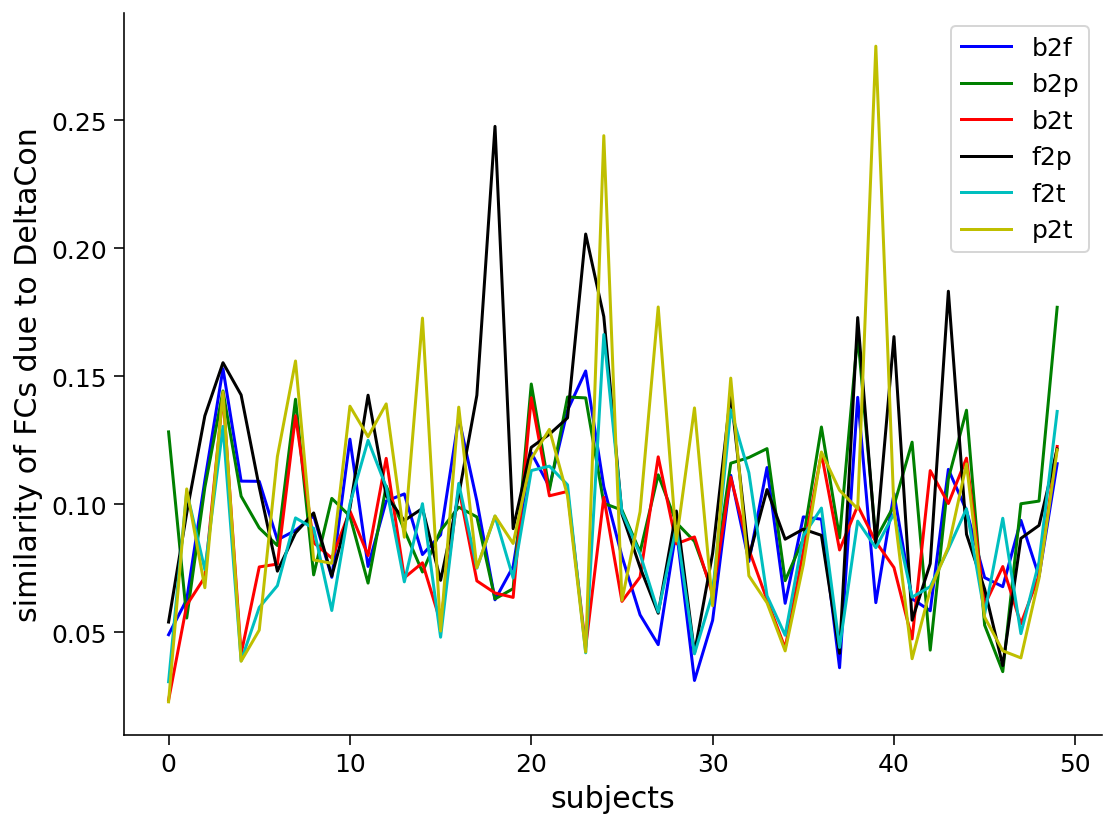

In [12]:
# similarity between FCs for each subject will be plotted
# e.g. b2f means body to face

colors = ['b', 'g', 'r', 'k', 'c', 'y']
labels = ['b2f', 'b2p', 'b2t', 'f2p', 'f2t', 'p2t']
plt.figure()

for i in range(6):
  plt.plot(list(range(N_SUBJECTS)), sim[i,:],color=colors[i],label=labels[i])

plt.xlabel('subjects')
plt.ylabel('similarity of FCs due to DeltaCon')
plt.legend()


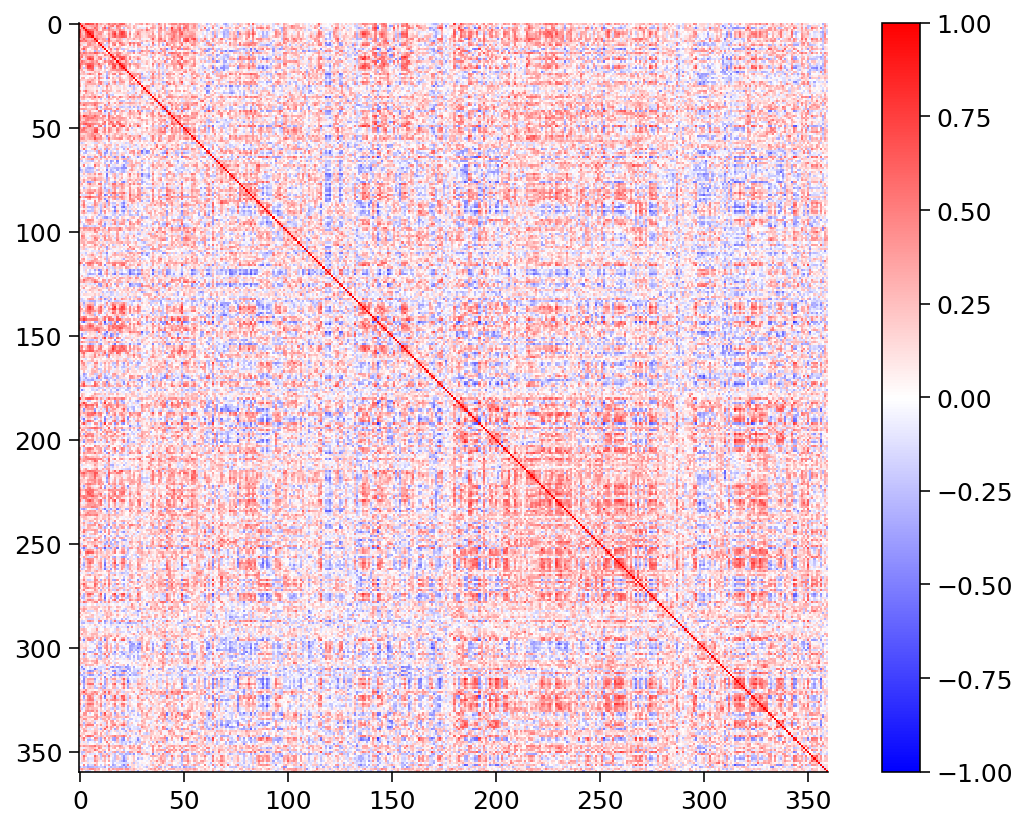

In [18]:
# take a look at the FC of body for the last subject
# fc[0]-> body  fc[1]-> faces  fc[2]->places  fc[3]->tools

plt.imshow(fc[0], interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'average similarity of functional connectivities between 4 catagories and on all participants ')

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


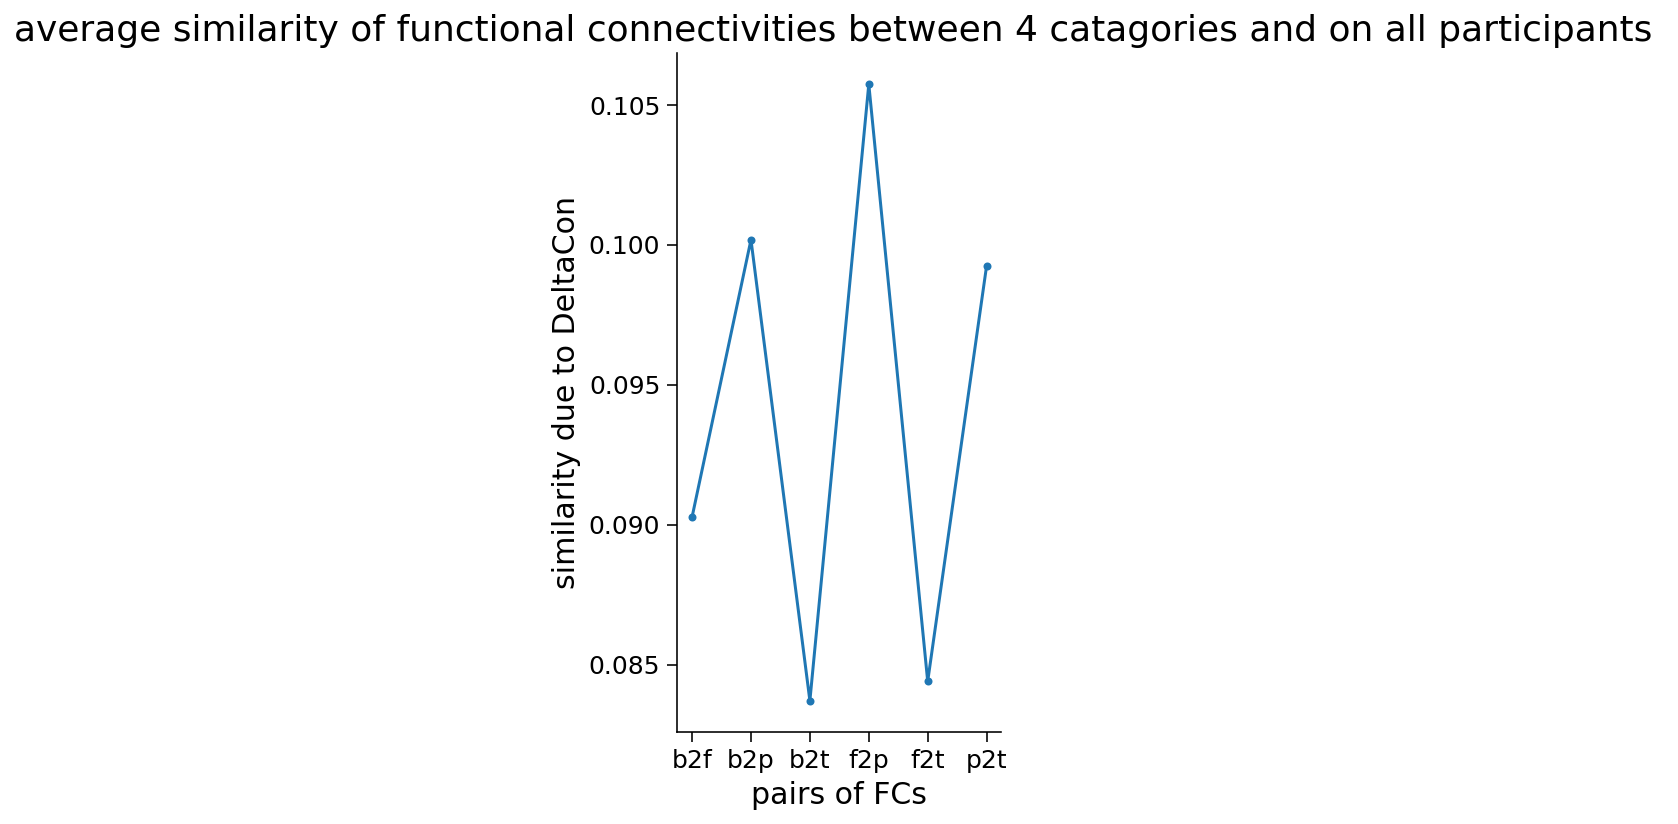

In [19]:
# to plot average similarity on all subjects

labels = ['b2f', 'b2p', 'b2t', 'f2p', 'f2t', 'p2t']
plt.plot(labels, np.mean(sim, axis=1), '.-')

plt.xlabel('pairs of FCs')
plt.ylabel('similarity due to DeltaCon')
plt.title('average similarity of functional connectivities between 4 catagories and on all participants ')

In the following cells we're ganna implement ANOVA analysis to make sure if the results are reliable

In [20]:
# to make necessary dataframe needed for ANOVA test from "sim"

import pandas as pd
sim_tr = np.concatenate(((np.array([range(50)])).T,sim.T), axis=1)
df = pd.DataFrame(sim_tr)
df.columns = ['ID','b2f', 'b2p', 'b2t', 'f2p', 'f2t', 'p2t']
# reshape the dataframe in long-format dataframe
df_melt = pd.melt(df.reset_index(), id_vars=['ID'], value_vars=labels)
# replace column names
df_melt.columns = ['ID', 'conditions', 'similarity']	
df_melt

,ID,conditions,similarity
0,0.0,b2f,0.049060
1,1.0,b2f,0.062762
2,2.0,b2f,0.109261
3,3.0,b2f,0.152925
4,4.0,b2f,0.109028
...,...,...,...
295,45.0,p2t,0.055907
296,46.0,p2t,0.042753
297,47.0,p2t,0.040000
298,48.0,p2t,0.071114


In [21]:
# to install pingouin which is required for ANOVA analysis

!pip install pingouin

     |████████████████████████████████| 205 kB 5.2 MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.12-py3-none-any.whl size=204754 sha256=68d2e48627cfbbd714566336b7085012db198a396c89c24ba777130fc70f8eee
  Stored in directory: /root/.cache/pip/wheels/5b/8a/ed/fafe2714a0f047d64fb582105b174b5e5218c82a0d787bbec4
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=a7a6297ab0b9be64cb0d0a719caaa858b6a5a2f9350a16a896c7bffa4a0379fe
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils


In [22]:
# one way ANAVO test

import pingouin as pg
res = pg.rm_anova(dv='similarity', within='conditions', subject='ID', data=df_melt, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,np2,eps
0,conditions,0.020790,5,0.004158,4.697495,0.000409,0.087481,0.543431
1,Error,0.216859,245,0.000885,NaN,NaN,NaN,NaN


In [23]:
# two way ANOVA test

import pingouin as pg
post_hocs = pg.pairwise_ttests(dv='similarity', within='conditions', subject='ID', padjust='fdr_bh', data=df_melt)
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,conditions,b2f,b2p,True,True,-2.570435,49.0,two-sided,0.013247,0.028024,fdr_bh,2.953,-0.331899
1,conditions,b2f,b2t,True,True,1.448972,49.0,two-sided,0.153715,0.256192,fdr_bh,0.409,0.232895
2,conditions,b2f,f2p,True,True,-3.199364,49.0,two-sided,0.002416,0.009062,fdr_bh,12.984,-0.418131
3,conditions,b2f,f2t,True,True,1.320609,49.0,two-sided,0.192767,0.289150,fdr_bh,0.348,0.201105
4,conditions,b2f,p2t,True,True,-1.114857,49.0,two-sided,0.270350,0.368659,fdr_bh,0.276,-0.216185
5,conditions,b2p,b2t,True,True,3.718482,49.0,two-sided,0.000516,0.004829,fdr_bh,51.662,0.569542
6,conditions,b2p,f2p,True,True,-0.870677,49.0,two-sided,0.388176,0.485220,fdr_bh,0.22,-0.148008
7,conditions,b2p,f2t,True,True,3.024261,49.0,two-sided,0.003960,0.011881,fdr_bh,8.402,0.527669
8,conditions,b2p,p2t,True,True,0.117747,49.0,two-sided,0.906750,0.906750,fdr_bh,0.155,0.022058
9,conditions,b2t,f2p,True,True,-3.238679,49.0,two-sided,0.002158,0.009062,fdr_bh,14.35,-0.607863
